# Проект для «Викишоп»

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Необходимо обучить модель классифицировать комментарии на позитивные и негативные. В распоряжении набор данных с разметкой о токсичности правок.

Необходимо построить модель со значением метрики качества *F1* не меньше 0.75. 

**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

## Подготовка данных

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

import re
import nltk 
from nltk.corpus import stopwords, wordnet
stopwords = set(stopwords.words('english'))
from nltk.stem import WordNetLemmatizer 
from sklearn.feature_extraction.text import TfidfVectorizer
from tqdm import tqdm

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import f1_score 

from catboost import CatBoostClassifier

import warnings
warnings.filterwarnings('ignore')

RANDOM_STATE = 42 

In [2]:
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\vasal\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [3]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\vasal\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [4]:
nltk.download('averaged_perceptron_tagger_eng')

[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     C:\Users\vasal\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!


True

In [5]:
data = pd.read_csv('toxic_comments.csv')
data.info()
data.tail()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  159292 non-null  int64 
 1   text        159292 non-null  object
 2   toxic       159292 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.6+ MB


,Unnamed: 0,text,toxic
159287,159446,""":::::And for the second time of asking, when ...",0
159288,159447,You should be ashamed of yourself \n\nThat is ...,0
159289,159448,"Spitzer \n\nUmm, theres no actual article for ...",0
159290,159449,And it looks like it was actually you who put ...,0
159291,159450,"""\nAnd ... I really don't think you understand...",0


Столбец "Unnamed: 0" не содержит никакой информации о тексте, его удалим

In [6]:
data = data.drop('Unnamed: 0', axis=1)
data.info()
data.tail()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159292 non-null  object
 1   toxic   159292 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ MB


,text,toxic
159287,""":::::And for the second time of asking, when ...",0
159288,You should be ashamed of yourself \n\nThat is ...,0
159289,"Spitzer \n\nUmm, theres no actual article for ...",0
159290,And it looks like it was actually you who put ...,0
159291,"""\nAnd ... I really don't think you understand...",0


Посмотрим есть ли повторяющиеся строки и при необходимости удалим их

In [7]:
print(data.duplicated().sum())

0


Повторяющихся строк нет

Оценим распределение значений целевого признака

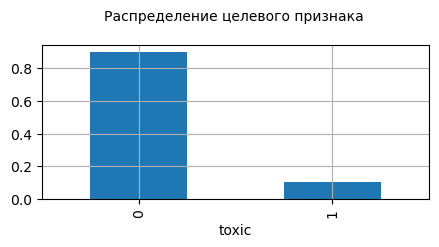

In [8]:
plt.figure(figsize=(5, 2))
data['toxic'].value_counts(normalize = (0,1)).plot.bar()
plt.title('Распределение целевого признака \n', fontsize=10)
plt.grid()

Целевой признак представлен неравномерно: класс 1 составляет ~ 10% от общего числа значений. Это необходимо будет учесть при обучении модели классификации.

Выполним леммитизацию данных

In [9]:
def clean_text(text):
    clean_text = re.sub(r'[^a-zA-Z]', ' ', text).lower()
    clean_text = "".join(clean_text)
    return clean_text

In [10]:
def get_wordnet_pos(word):
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN)

In [11]:
lemmatizer = WordNetLemmatizer()

def lemmatize(text):
    lemm_list = []
    for i in nltk.word_tokenize(text):
        lemm_word = lemmatizer.lemmatize(i, get_wordnet_pos(i))
        lemm_list.append(lemm_word)
    lemm_text = " ".join(lemm_list)
    return lemm_text

In [12]:
corpus = list(data['text'])

lemm=[]
for i in tqdm(range(len(corpus))):
    lemm.append(lemmatize(clean_text(corpus[i])))
data['lemmatize']=pd.Series(lemm, index=data.index)
data.head()

100%|█████████████████████████████████████████████████████████████████████████| 159292/159292 [08:53<00:00, 298.66it/s]


,text,toxic,lemmatize
0,Explanation\nWhy the edits made under my usern...,0,explanation why the edits make under my userna...
1,D'aww! He matches this background colour I'm s...,0,d aww he match this background colour i m seem...
2,"Hey man, I'm really not trying to edit war. It...",0,hey man i m really not try to edit war it s ju...
3,"""\nMore\nI can't make any real suggestions on ...",0,more i can t make any real suggestion on impro...
4,"You, sir, are my hero. Any chance you remember...",0,you sir be my hero any chance you remember wha...


Разбиваем данные на тренировочную и тестовую выборки с учетом неравномерного распределения классов целевого признака. Валидационную не выделяем в связи с применением в паплайне кросс-валидации 

In [13]:
data = data.drop(['text'], axis=1)

In [14]:
features = data.drop(['toxic'], axis = 1)
target = data['toxic']

features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size = 0.25, shuffle=True,
    random_state = RANDOM_STATE, stratify=target)

## Обучение

In [15]:
vectoriser = TfidfVectorizer(stop_words=list(stopwords))

pipe_final = Pipeline([
    ('vectoriser', vectoriser), 
    ('models', LogisticRegression()),
])

In [16]:
param = [
    {
        'models': [LogisticRegression()],
        'models__C': [0.1, 1.0, 10.0]
    },
    {
        'models': [RandomForestClassifier(random_state=RANDOM_STATE)],
        'models__n_estimators': [50, 100],
        'models__max_depth': [3, 5]
    },
    {
        'models': [CatBoostClassifier(random_state=RANDOM_STATE)],
        'models__iterations': [50, 100]
    }
] 

In [17]:
grid_search = GridSearchCV(pipe_final, param, scoring='f1', n_jobs=-1)

In [18]:
corpus_train = features_train['lemmatize'].values
grid_search.fit(corpus_train, target_train)

GridSearchCV(estimator=Pipeline(steps=[('vectoriser',
                                        TfidfVectorizer(stop_words=['not',
                                                                    'how', 'it',
                                                                    "you're",
                                                                    'd', 'then',
                                                                    'yours',
                                                                    'are',
                                                                    'more',
                                                                    'before',
                                                                    'some',
                                                                    'no',
                                                                    "it'll",
                                                                    'does',
                                                                    'about',
                                                                    'any',
                                                                    "couldn't",
                                                                    'nor',
                                                                    'once',
                                                                    'shouldn',
                                                                    "that'll",
                                                                    'am',
                                                                    "you'd",
                                                                    's',
                                                                    'until',
                                                                    'whom',
                                                                    'didn',
                                                                    'here',
                                                                    'weren',
                                                                    'by', ...])),
                                       ('models', LogisticRegression())]),
             n_jobs=-1,
             param_grid=[{'models': [LogisticRegression()],
                          'models__C': [0.1, 1.0, 10.0]},
                         {'models': [RandomForestClassifier(random_state=42)],
                          'models__max_depth': [3, 5],
                          'models__n_estimators': [50, 100]},
                         {'models': [<catboost.core.CatBoostClassifier object at 0x000001F48FEE5E20>],
                          'models__iterations': [50, 100]}],
             scoring='f1')

In [19]:
print('Лучшая модель:\n\n', grid_search.best_estimator_)
print('Параметры лучшей модели:', grid_search.best_params_)
print ('Метрика лучшей модели:', grid_search.best_score_)

Лучшая модель:

 Pipeline(steps=[('vectoriser',
                 TfidfVectorizer(stop_words=['not', 'how', 'it', "you're", 'd',
                                             'then', 'yours', 'are', 'more',
                                             'before', 'some', 'no', "it'll",
                                             'does', 'about', 'any', "couldn't",
                                             'nor', 'once', 'shouldn',
                                             "that'll", 'am', "you'd", 's',
                                             'until', 'whom', 'didn', 'here',
                                             'weren', 'by', ...])),
                ('models', LogisticRegression(C=10.0))])
Параметры лучшей модели: {'models': LogisticRegression(), 'models__C': 10.0}
Метрика лучшей модели: 0.7738549631038246


Лучший результат (f1=0.77) показала модель Логистической регрессии с параметром С=10. Проверим ее на тестовых значениях.

In [20]:
corpus_train = features_train['lemmatize'].values
corpus_test = features_test['lemmatize'].values
tf_idf_train = vectoriser.fit_transform(corpus_train)
tf_idf_test = vectoriser.transform(corpus_test)
model = LogisticRegression(C=10.0)
model.fit(tf_idf_train, target_train)
predict = model.predict(tf_idf_test)
print('F1:', round(f1_score(target_test, predict),2))

F1: 0.77


На тестовой выборке модель Логистической регрессии также показала хороший результат. Модель может использоваться для классификации комментариев.

## Выводы

В ходе выполнения задания были загружены данные содержащие комментарии и их оценку позитивности. 
<br>Исходный файл содержал 159292 комментария. В ходе предобработки удален столбец с номером комментария. Проведена проверка на повторяющиеся строки, таких найдено не было.
<br>Распределение целевого признака показало дисбаланс классов: класс 0 представлен 90% значений, на класс 1 приходится всего 10% от общего числа данных. Данный дисбаланс был учтен при делении на выборки применением параметра stratify.
<br>Была проведена леммитизация данных, очищение данных от стоп-слов, а также перевод текста в векторное представление. 
<br>По данным векторного представления были обучены модели: Логистической регрессии, рандомного леса и бустинга. С помощью паплайна было определено, что лучше всего с данной задачей справилась модель Логистической регрессии.
<br>На тестовой выборке Логистическая регрессия также повторила хороший результат, удовлетворив условиию задачи f1>0.75. Точнее ее результат на тестовой выборке 0.77